# Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Set Pulse

Text(0.5, 1.0, 'Pulses over time')

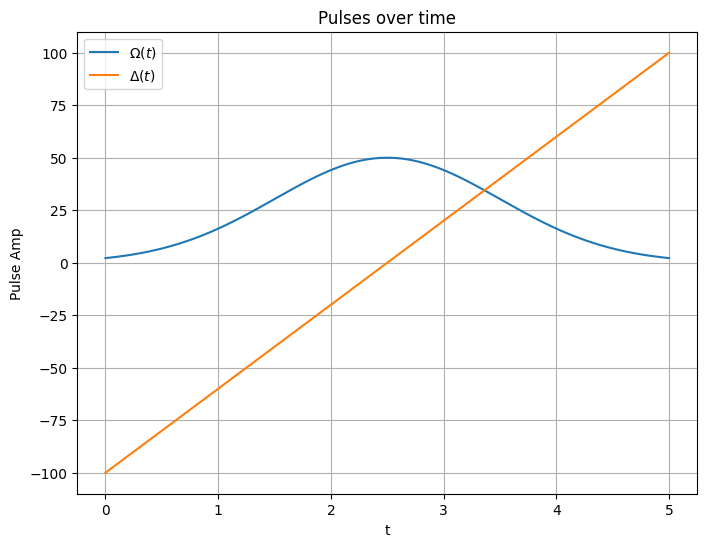

In [4]:
# defining time dependant coefs
T = 5
t = np.linspace(0, T, 1000)
sigma = 1
omega_max = 50
omega_t = omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 2*omega_max*(t / (T/2) - 1)

# Plot the wave
plt.figure(figsize=(8, 6))
plt.plot(t, omega_t, label=r'$\Omega(t)$')
plt.plot(t, delta_t, label=r'$\Delta(t)$')
plt.xlabel("t")
plt.ylabel("Pulse Amp")
plt.grid(True)
plt.legend()
plt.title("Pulses over time")


# Defining Stabilizers for 4-qubit code

In [5]:
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

# Define the stabilizer generators for the 5-qubit bit-flip code
g1 = tensor(X, X, X, X)
g2 = tensor(Z, Z, Z, Z)
g3 = tensor(X, Y, Z, I)

stabilizers = [
    g1,
    g2,
    g3
]

X_L = tensor(Y, I, Y, I)
Z_L = tensor(Z, Z, I, I)
Y_L = -tensor(I, X, X, I)


In [6]:
basis_states = [basis(2, 0), basis(2, 1)]

# Define the logical zero state |0_L>
logical_zero = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
                1j*tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1]) +
                1j*tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0]) +
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1])).unit()

logical_one = X_L * logical_zero

# Applying error
# error = tensor(I, X, I, X)
# logical_zero = error * logical_zero
# logical_one = error * logical_one

# Define projection operators
P0 = logical_zero * logical_zero.dag()
P1 = logical_one * logical_one.dag()
P_tot = P0 + P1

-300 1.0 0.0
-300 0.0 1.0
-100 0.0 0.0
-100 0.0 0.0
-100 0.0 0.0
-100 0.0 0.0
-100 0.0 0.0
-100 0.0 0.0
100 0.0 0.0
100 0.0 0.0
100 0.0 0.0
100 0.0 0.0
100 0.0 0.0
100 0.0 0.0
300 0.0 0.0
300 0.0 0.0
{-300: 2, -100: 6, 100: 6, 300: 2}


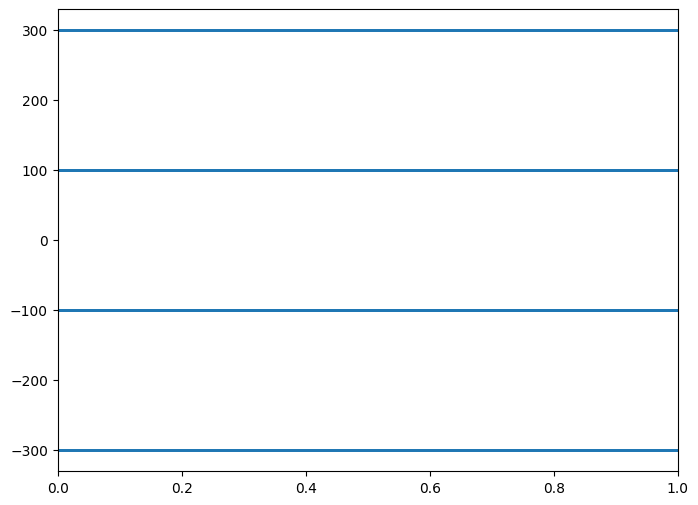

In [55]:
Ep = 100
Hp = -Ep*(g1 + g2 + g3)

eigenvalues, eigenstates = Hp.eigenstates()

energies = {}
colors = [
    'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan',
    'magenta', 'yellow', 'lime', 'teal', 'gold', 'navy'
]

plt.figure(figsize=(8, 6))

# Loop through both arrays
for energy, state in zip(eigenvalues, eigenstates):
    
    energy = int(np.round(energy, 1))
    
    if energy not in energies.keys():
        energies[energy] = 1
    else:
        energies[energy] += 1    
    plt.axhline(y = energy, linestyle = '-', linewidth = 2)
    
    proj_zero = np.abs(logical_zero.overlap(state))**2
    proj_one = np.abs(logical_one.overlap(state))**2

    print(energy, np.round(proj_zero), np.round(proj_one))
print(energies)

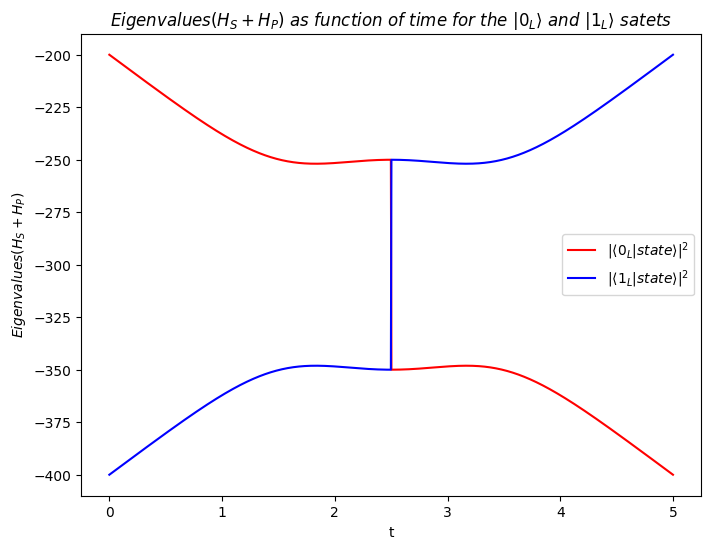

In [22]:
one_eigens = []
zero_eigens = []

for i, t_step in enumerate(t):
    H_S = omega_t[i] * X_L + delta_t[i] * Z_L + Hp
    eigenvalues, eigenstates = H_S.eigenstates()
    
    for energy, state in zip(eigenvalues, eigenstates):        
        proj_zero = np.round(np.abs(logical_zero.overlap(state))**2)
        proj_one = np.round(np.abs(logical_one.overlap(state))**2)
        if proj_zero:
            zero_eigens.append(energy)
        if proj_one:
            one_eigens.append(energy)

plt.figure(figsize=(8, 6))
plt.plot(t, one_eigens, color='r', label =r'$| \langle 0_{L} | state \rangle | ^{2}$')
plt.plot(t, zero_eigens, color='b', label =r'$| \langle 1_{L} | state \rangle | ^{2}$')
plt.xlabel('t')
plt.ylabel(r'$Eigenvalues(H_{S} + H_{P})$')
plt.title(r'$Eigenvalues(H_{S} + H_{P}) \ as \ function \ of \ time \ for \ the \ |0_{L} \rangle \ and \ |1_{L} \rangle \ satets$')
plt.legend()

In [81]:
def qobj_to_hashable(qobj, precision=10):
    data_array = qobj.full()
    
    real_part = np.round(np.real(data_array), precision).flatten()
    imag_part = np.round(np.imag(data_array), precision).flatten()
    
    combined_tuple = tuple(np.concatenate([real_part, imag_part]))
    
    return combined_tuple

def tuple_to_qobj(hash_tuple, dims, shape):
    # Split the hash tuple into real and imaginary parts
    n = len(hash_tuple) // 2
    real_part = np.array(hash_tuple[:n])
    imag_part = np.array(hash_tuple[n:])
    
    # Recreate the complex matrix from the real and imaginary parts
    complex_matrix = real_part + 1j * imag_part
    
    # Reshape the flat array into the original shape of the Qobj
    complex_matrix = complex_matrix.reshape(shape)
    
    # Recreate the Qobj with the given dims
    qobj_reconstructed = Qobj(complex_matrix, dims=dims)
    
    return qobj_reconstructed

In [88]:
H_S = omega_t[0] * X_L + delta_t[0] * Z_L + Hp
    
states = {}
eigenvalues, eigenstates = H_S.eigenstates()

for energy, state in zip(eigenvalues, eigenstates):
    states[qobj_to_hashable(state)] = [energy]

In [80]:
dims = [[2, 2, 2, 2], [1, 1, 1, 1]]
shape = (16, 1)

for i, t_step in enumerate(t):
    if i == 0:
        continue
        
    H_S = omega_t[i] * X_L + delta_t[i] * Z_L + Hp
    eigenvalues, eigenstates = H_S.eigenstates()
    
    for energy, state in zip(eigenvalues, eigenstates):
        for state_0 in states.keys():

            proj = np.round(np.abs(tuple_to_qobj(state_0, dims, shape).overlap(state))**2)
            if proj == 1:
                states[state_0].append(energy)

for key, val in states.items():
    print(len(val))

1000
868
983
882
1000
908
888
981
820
973
831
1004
835
984
821
993
